In [1]:
#This notebook produces a reliability diagram (empirical class probablity as function of predicted class probability) before and
#after calibration. The closer the function is to the identity after calibration the better the calibration. The figure
#configuration comes from https://github.com/hollance/reliability-diagrams but how we compute predicted and empirical class
#probability is different.
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow
from tensorflow import keras

2023-07-12 22:46:19.897023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 22:46:20.552725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def compute_calibration(true_labels, pred_labels, predicted_probabilities, num_bins):
    """Collects predictions into bins used to draw a reliability diagram (predicted on x axis and empirical on y axis).
    Arguments:
        true_labels: the true labels (class) for the test examples
        pred_labels: the predicted labels (class) for the test examples
        predicted_probabilities: the predicted probability of the example belonging to class one (dependent class)
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    Returns a dictionary containing the following NumPy arrays:
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        empirical_probabilities: the empirical probability for class one (dependent class) for each bin
        predicted_probabilities: the predicted probability for class one (dependent class) for each bin
    """
    assert(len(predicted_probabilities) == len(pred_labels))
    assert(len(predicted_probabilities) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(predicted_probabilities, bins, right=True)

    bin_empirical_probabilities = np.zeros(num_bins, dtype=np.float)
    bin_predicted_probabilities = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_empirical_probabilities[b] = np.mean(1 == true_labels[selected])
            bin_predicted_probabilities[b] = np.mean(predicted_probabilities[selected])
            bin_counts[b] = len(selected)


    return { "empirical_probabilities": bin_empirical_probabilities, 
             "predicted_probabilities": bin_predicted_probabilities, 
             "counts": bin_counts, 
             "bins": bins}

In [12]:
#This helper function creates the matplotlib figure.

def reliability_diagram_subplot(ax, bin_data,
                                 draw_bin_importance=False,
                                 xlabel="Predicted Class Probability (C=1)", 
                                 ylabel="Empirical Class Probability"):
    """Draws a reliability diagram into a subplot."""
    empirical_probabilities = bin_data["empirical_probabilities"]
    predicted_probabilities = bin_data["predicted_probabilities"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(empirical_probabilities - predicted_probabilities), 
                     bottom=np.minimum(empirical_probabilities, predicted_probabilities), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Miscalibration")

    #plot identify function in dashed gray
    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")

    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([.1*i for i in range(2,12,2)]) 
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel(ylabel, fontsize=25)

    ax.legend(handles=[gap_plt], fontsize = 18)


def _reliability_diagram_combined(fig_name, bin_data, title, 
                                  draw_bin_importance, 
                                  figsize, dpi, return_fig):
    """Draws a reliability diagram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0])

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    plt.tight_layout()
    plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
    plt.title(title, fontsize = 30)

    reliability_diagram_subplot(ax, bin_data, draw_bin_importance,
                                xlabel="Predicted Probability", ylabel = "Empirical Probability")



    plt.savefig(fig_name, bbox_inches = "tight")

    if return_fig: return fig

In [13]:
def reliability_diagram(true_labels, pred_labels, predicted_probabilities, num_bins, fig_name, 
                        title, figsize=(10, 10), dpi=72, return_fig=False):
    """Draws a reliability diagram
    
    First, the model's predictions are divided up into bins based on the predicted
    probability for class one (dependent class). The independent class is class zero.
    The reliability diagram shows the gap between empirical and predicted probability
    in each bin. These are the red bars. Ideally, there is no gap.
    In that case, the model is properly calibrated.
    
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        predicted_probabilities: the predicted probability of the example belonging to class one (dependent class)
        num_bins: number of bins
        title: title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, predicted_probabilities, num_bins)
    return _reliability_diagram_combined(fig_name, bin_data, title,
                                         figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig, draw_bin_importance = False)

In [14]:
#Helper function to compute the predicted class for a pair of spatial field and paramter. The predicted label of a pair is class
#one (the dependent class) if the predicted probability from the classifier for the pair is greater than .5.
def compute_prediction_class(prediction):

    if(prediction >= .5):
        return np.array([1])
    else:
        return np.array([0])

In [15]:
#variables needed for loading data for before and after calibration reliability diagrams
image_size = 25
image_name = "25_by_25"
version = "final_version"
local_folder = "/home/juliatest/Desktop/likelihood_free_inference/neural_likelihood/brown_resnick"

In [16]:
#Use test data to produce reliability diagrams

#First, load data for reliability diagram before calibration
test_classifier_outputs_before_calibration_filename = (local_folder + "/evaluate_nn/calibration/data/" 
                                                       + image_name + "/" + version + 
                                                       "/test/precalibration_test_" + version + "_classifier_results_300_reps_50.npy")
#load the classifier outputs
#the closer the probability is to 1, the closer it is to the dependent class (which for this file is class 1),
#the independent class is 0
test_prediction_probabilities = (np.load(test_classifier_outputs_before_calibration_filename))[:,1]
total_test_number = test_prediction_probabilities.shape[0]
test_classes_filename = (local_folder + "/evaluate_nn/calibration/data/" + 
                         image_name + "/" + version + 
                         "/test/precalibration_test_classes_300_reps_50.npy")
#load the true class labels for the test data (class 1 corresponds to dependent class and class 0 corresponds to independent class)
test_classes = ((np.load(test_classes_filename))[:,1]).reshape((total_test_number, 1))

#compute the predicted classes using the classifier probabilities and the helper function compute_prediction_class.
test_prediction_classes = (np.asarray([compute_prediction_class(test_prediction_probabilities[i]) 
                                       for i in range(0, total_test_number)]))

/tmp/ipykernel_28439/2186175333.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_empirical_probabilities = np.zeros(num_bins, dtype=np.float)
/tmp/ipykernel_28439/2186175333.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_predicted_probabilities = np.zeros(num_bins, dtype=np.float)
/tmp/ipykernel_28439/2186175333.py:25: D

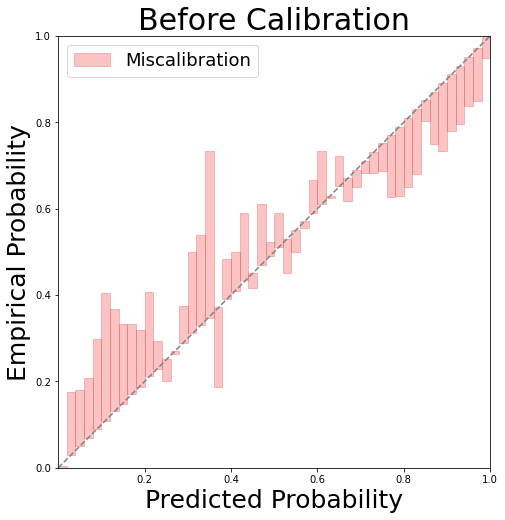

In [17]:
#plot the diagram before calibration
reliability_diagram(test_classes, test_prediction_classes, test_prediction_probabilities, num_bins=50,
                        figsize=(10, 10), dpi=72, return_fig=False, 
                        fig_name = (local_folder + "/evaluate_nn/visualizations/produce_reliability_diagrams/diagrams/"
                                    + image_name + "/" + version + "/uncalibrated/dependent_class_reliability_diagram.png"),
                        title = "Before Calibration")

In [20]:
#Next, produce reliability diagram for after calibration

#Load logistic model and data for reliabilityd diagram for after calibration
logistic_model_filename = (local_folder + "/evaluate_nn/calibration/model/" + image_name + 
                           "/" + version + "/logistic_regression_model_wtih_logit_transformation.pkl")
with open(logistic_model_filename, "rb") as file:
    logistic_regression_model = pickle.load(file)

test_classifier_outputs = np.load((local_folder + "/evaluate_nn/calibration/data/"
                                    + image_name + "/" + version + 
                                   "/test/precalibration_test_" + version + "_classifier_results_300_reps_50.npy"))

#Transform the classifier outputs with logit transformation
test_logit = (np.log(test_classifier_outputs/(1-test_classifier_outputs)))[:,0]
test_logit = test_logit.reshape((-1,1))

#Make sure there are no nan and inf values
test_logit[test_logit == np.inf] = np.amax(test_logit[test_logit != np.inf])
test_logit[test_logit == np.NaN] = np.amax(test_logit[test_logit != np.inf])
test_logit[test_logit == -1*np.inf] = np.amin(test_logit[test_logit != -1*np.inf])

#Use logistic regression model to get calibrated probabilities of test data
calibrated_test_prediction_probabilities = logistic_regression_model.predict_proba(test_logit)[:,0]
calibrated_test_prediction_classes = (np.asarray([compute_prediction_class(calibrated_test_prediction_probabilities[i]) 
                                       for i in range(0, total_test_number)]))


/tmp/ipykernel_28439/1596767367.py:14: RuntimeWarning: divide by zero encountered in log
  test_logit = (np.log(test_classifier_outputs/(1-test_classifier_outputs)))[:,0]


/tmp/ipykernel_28439/2186175333.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_empirical_probabilities = np.zeros(num_bins, dtype=np.float)
/tmp/ipykernel_28439/2186175333.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bin_predicted_probabilities = np.zeros(num_bins, dtype=np.float)
/tmp/ipykernel_28439/2186175333.py:25: D

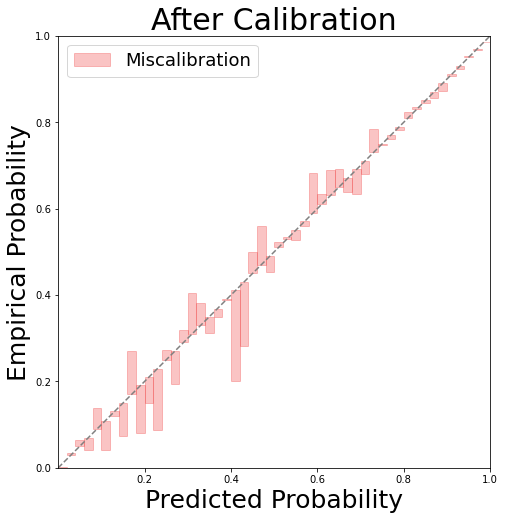

In [21]:
reliability_diagram(test_classes, calibrated_test_prediction_classes, calibrated_test_prediction_probabilities, num_bins=50,
                        figsize=(10, 10), dpi=72, return_fig=False, 
                        title = "After Calibration",
                        fig_name = (local_folder + "/evaluate_nn/visualizations/produce_reliability_diagrams/diagrams/"
                                    + image_name + "/" + version + "/calibrated/dependent_class_reliability_diagram.png"))